In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [3]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


In [4]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

# 프로젝트: 뉴스기사 요약해보기

# Step 1. 데이터 수집

In [5]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)

,headlines,text
89285,Startup offers to freeze employees' bodies whe...,San Francisco-based machine learning startup N...
94347,Library that lets users borrow people started ...,A group of students have started the 'Human Li...
36458,"I played too many dot balls, concedes Kohli af...",Reacting to Royal Challengers Bangalore's loss...
23129,"2 of 8 men, accused of raping pregnant goat, a...",Haryana Police on Thursday arrested two of the...
35441,Obama never did enough to stop Syrian regime: ...,Slamming Barack Obama for not taking action ag...
15783,CBSE cancels affiliation of school where girl ...,CBSE has cancelled the affiliation of a Dehrad...
88709,There might not be an Aussie team for Ashes: D...,Australian cricketer David Warner has said the...
7487,"Jet Airways to get new investor in 3 months, C...",Jet Airways would bring on board a new investo...
52183,Trump says silly things because he gets confus...,"Claiming that Donald Trump is not racist, the ..."
11342,End casteism and we will forego reservation: U...,When asked about whether reservation should en...


# Step 2. 데이터 전처리하기 (추상적 요약)
- 전처리를 사용하여 텍스트를 정규화 또는 정제 
- 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민

## null 제거

In [6]:
data.drop_duplicates(subset = ['text'], inplace=True)
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))


전체 샘플수 : 98360


## 전처리

In [7]:
# text 데이터에 대한 전처리
clean_text = []
print(len(data))
cnt = 0
cnt_process = 0
for s in data['text']:
    clean_text.append(preprocess_sentence(s))
    cnt += 1
    if cnt == 10000:
        cnt_process += 1
        cnt = 0
        print(cnt_process)
print(cnt_process+cnt)

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

98360
1
2
3
4
5
6
7
8
9
8369
Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years

In [8]:
# headlines 데이터에 대한 전처리
clean_headlines = []
print(len(data))
cnt = 0
cnt_process = 0
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))
    cnt += 1
    if cnt == 10000:
        cnt_process += 1
        cnt = 0
        print(cnt_process)

print("headlines 전처리 후 결과: ", clean_headlines[:5])

98360
1
2
3
4
5
6
7
8
9
headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


## null 제거

In [9]:
data['text'] = clean_text
data['headlines'] = clean_headlines


# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)

In [10]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 샘플 길이 맞추기

### 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


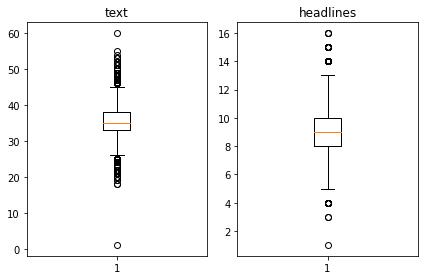

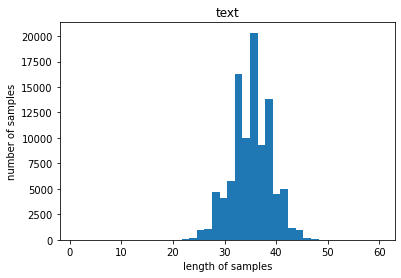

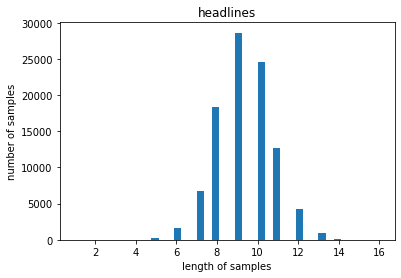

In [11]:
# 길이 분포 출력
import matplotlib.pyplot as plt

# 리스트로 변환
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
max_text = 40
max_headlines = 11

below_threshold_len(max_text, data['text'])
below_threshold_len(max_headlines, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [15]:
# 길이가 긴 문장 제거
data = data[data['text'].apply(lambda x: len(x.split()) <= max_text)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= max_headlines)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


## 시작 토큰, 종료 토큰 추가

In [16]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

In [17]:
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [18]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블


## train data, test data 분리

In [19]:
encoder_input.shape

(85843,)

In [55]:
# shuffle
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

# 재정렬
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]


[61053 72386 54711 ... 84788  8434 65230]


In [56]:
n_of_val = int(len(encoder_input)*0.4)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 34337


In [57]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 51506
훈련 레이블의 개수 : 51506
테스트 데이터의 개수 : 34337
테스트 레이블의 개수 : 34337


## 단어 집합(vocabulary) 을 만들기

In [58]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성


### 빈도수 낮은 데이터 제외

In [59]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 57553
등장 빈도가 6번 이하인 희귀 단어의 수: 39680
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17873
단어 집합에서 희귀 단어의 비율: 68.94514621305579
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.556861003936953


토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있어요.

단어 집합 크기 제한하는 이유???

In [60]:
src_vocab = 17000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성


## 인코딩

In [61]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[4174, 62, 3, 56, 1017, 212, 7406, 28, 79, 122, 4550, 5093, 10382, 1455, 37, 369, 159, 21, 177, 187, 15, 2459, 49, 990, 1400, 6585, 2139, 961, 62, 1289, 441, 7, 15593, 36, 8945, 86, 1698, 434, 62, 369], [6, 42, 246, 77, 2044, 6015, 2280, 2523, 13249, 1393, 1621, 36, 4818, 92, 1635, 15594, 6710, 11613, 36, 246, 2806, 233, 1184, 1721, 2704, 6015, 11614, 13249, 24, 4175, 6837, 1906, 7407, 5327, 4658, 1636], [669, 324, 927, 454, 5829, 155, 290, 6838, 12084, 3405, 113, 249, 928, 664, 264, 8087, 8289, 4219, 163, 3459, 11, 664, 264, 16586, 7898, 13929, 3822, 461, 664, 264, 270, 870, 640, 17, 70]]


## headlines 데이터도 동일하게 진행

In [62]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)


In [63]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 25580
등장 빈도가 5번 이하인 희귀 단어의 수: 17279
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8301
단어 집합에서 희귀 단어의 비율: 67.54886630179828
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.317252484975127


In [64]:
tar_vocab = 8300
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2501, 189, 3432, 6919, 5, 2143, 5946, 33, 609], [1, 6920, 88, 22, 7, 3, 1948, 1949, 137], [1, 748, 669, 4, 1406, 332, 2435, 555], [1, 941, 149, 12, 22, 5, 3309, 258, 1207], [1, 4928, 4671, 26, 12, 22, 5222, 3, 9, 3310, 23]]
target
decoder  [[2501, 189, 3432, 6919, 5, 2143, 5946, 33, 609, 2], [6920, 88, 22, 7, 3, 1948, 1949, 137, 2], [748, 669, 4, 1406, 332, 2435, 555, 2], [941, 149, 12, 22, 5, 3309, 258, 1207, 2], [4928, 4671, 26, 12, 22, 5222, 3, 9, 3310, 23, 2]]


## 다시 null 제거

In [65]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 51505
훈련 레이블의 개수 : 51505
테스트 데이터의 개수 : 34337
테스트 레이블의 개수 : 34337


## 패딩

In [66]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=max_text, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=max_text, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_headlines, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=max_headlines, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=max_headlines, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=max_headlines, padding='post')


# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
- 어텐션 메커니즘을 사용한 seq2seq를 설계

In [67]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

## 테스트 모델 설계

In [68]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(max_text,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])


# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2176000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [69]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
202/202 [==============================] - 127s 586ms/step - loss: 6.0020 - val_loss: 5.5706
Epoch 2/50
202/202 [==============================] - 118s 586ms/step - loss: 5.4987 - val_loss: 5.2675
Epoch 3/50
202/202 [==============================] - 117s 579ms/step - loss: 5.1890 - val_loss: 5.0351
Epoch 4/50
202/202 [==============================] - 116s 573ms/step - loss: 4.9458 - val_loss: 4.8529
Epoch 5/50
202/202 [==============================] - 115s 571ms/step - loss: 4.7278 - val_loss: 4.7135
Epoch 6/50
202/202 [==============================] - 116s 575ms/step - loss: 4.5424 - val_loss: 4.5682
Epoch 7/50
202/202 [==============================] - 116s 572ms/step - loss: 4.3828 - val_loss: 4.4762
Epoch 8/50
202/202 [==============================] - 115s 572ms/step - loss: 4.2401 - val_loss: 4.3847
Epoch 9/50
202/202 [==============================] - 115s 570ms/step - loss: 4.1122 - val_loss: 4.3335
Epoch 10/50
202/202 [==============================] - 118s 582m

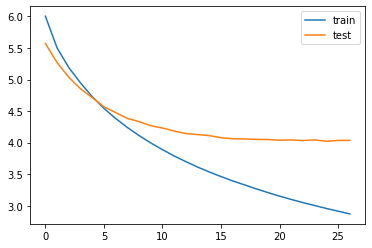

In [70]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 설계

In [72]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(max_text, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [73]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (max_headlines-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


# 인퍼런스 모델 테스트

In [74]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp


## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
- 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [75]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, max_text)))
    print("\n")

원문 : block development officer bihar district started new initiative asking hindu couples take eight wedding extra cleanliness pledge created team officials going weddings district without formal invitation asking couples take eighth 
실제 요약 : bihar officials ask couples to take th cleanliness 
예측 요약 :  up govt orders to build wedding in up village


원문 : singh son named ex husband jyoti randhawa said difficult bring child single parent society longer towards divorce single become normal things added said living balanced life parents 
실제 요약 : difficult to bring up child as single parent 
예측 요약 :  my wife is my son says wife


원문 : us president donald trump thursday tweeted made recordings tapes conversations fbi director james comey ending months speculation whether tapes exist notably comey said hoped recordings conversations president us senate committee earlier month 
실제 요약 : do not have tapes of with comey donald trump 
예측 요약 :  trump calls he he called him for his film


원문 : new f

예측 요약 :  first look of rajkummar rao starrer pad man out


원문 : kerala cm pinarayi vijayan assured support man protesting days custodial death brother one four accused cops demanded cbi inquiry case police official added four accused willing give lakh deceased family found guilty 
실제 요약 : kerala cop accused in custodial death demands cbi probe 
예측 요약 :  punjab cm orders death of killing cm in kerala


원문 : england woman cricketer danielle wyatt took instagram share video india player arjun tendulkar walking lord ground rain second england india test get work arjun wyatt heard asking arjun ground duties arjun currently part mcc young cricketers training lord 
실제 요약 : get to work eng woman cricketer as arjun helps ground staff 
예측 요약 :  fan who fan fan gives fan to fan who fan


원문 : half smoked former british pm winston churchill trip paris auctioned nearly lakh said kept british crew flew churchill paris photo signed churchill shows hand also auctioned 
실제 요약 : half auctioned for lakh 

예측 요약 :  bjp leader booked for calling fb fb for fb


원문 : juventus forward cristiano ronaldo former girlfriend said give evidence favour footballer rape case never ever aggressive towards even near cannot see forcing holding someone added american woman alleged ronaldo raped hotel 
실제 요약 : cannot see ronaldo forcing someone ex girlfriend on rape claims 
예측 요약 :  rape allegations me ronaldo on rape allegations


원문 : rats branch indian bank uttar pradesh allegedly made burglar alarm go monday officials holiday due branch manager police rushed spot went police said found nothing suspicious except rats running near alarm system 
실제 요약 : rats make burglar go off in up bank 
예측 요약 :  up police station officials over stealing


원문 : enforcement directorate monday conducted multiple searches connection money laundering case vadodara based diamond power infrastructure allegedly cheated banks crore company corporate office factories residential premises executives raided ed probing defaulted l

# Step 5. Summa을 이용해서 추출적 요약해보기
- 추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 
- 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

## summarize 사용하기


Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아볼게요.

- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
    - 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [76]:
import requests
from summa.summarizer import summarize


In [77]:
data_summ = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data_summ.sample(10)


,headlines,text
6876,Body of 22-yr-old man found at same spot where...,The body of a 22-year-old man was found on Sun...
85695,Never touched a rupee of black money: NDTV's P...,"NDTV Co-founder Prannoy Roy has said he, his w..."
21668,Usain Bolt demands black car to reach club fro...,Jamaica's eight-time Olympic gold medalist Usa...
39643,"After Arbaaz, Sajid Khan named in IPL betting ...",Dawood Ibrahim-linked bookie Sonu Jalan has re...
47720,"Woman poses as a man, marries 2 women for dowr...",Police have arrested a woman for allegedly pos...
50748,Teletubbies' Tinky Winky actor Simon Barnes pa...,"Simon Barnes, the actor who played Tinky Winky..."
5752,40-yr-old teacher protesting outside J'khand m...,A 40-year-old para-teacher died during a night...
91262,Carpet bomb Kashmir to stop militants: VHP's P...,VHP leader Pravin Togadia on Friday demanded t...
77807,Bomb shelters' sale surges in Japan amid North...,The sale of bomb shelters has increased in Jap...
87987,Boxer knocks out opponent with a seven-punch c...,Mexican boxer David 'Red Flag' Benavidez defea...


In [99]:
for idx in range(100):
    text = data_summ['text'][idx]
    print(idx)
    print('sentence:')
    print(text)
    print('Summary:')
    print(summarize(text, ratio=0.3))

    print('Summary:')
    print(summarize(text, words=15))

0
sentence:
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
Summary:

Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.
1
sentence:
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
Summary:

Summary:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
2
sent

sentence:
Apple CEO Tim Cook said the company plans to lower some iPhones' prices in markets with currencies that weakened against the US dollar in the past year. "WeÃ¢ÂÂve decided to go back to (iPhone prices) more commensurate with...local prices...a year ago," Cook added. The price cuts, in hopes of increasing sales, are reportedly occurring for second time in 12 years.
Summary:

Summary:
"WeÃ¢ÂÂve decided to go back to (iPhone prices) more commensurate with...local prices...a year ago," Cook added.
71
sentence:
Scientists in Australia's Flinders University are testing a wetsuit prototype that could protect its wearer after a shark attack. The suit, made of synthetic material similar to the material used in bulletproof vests, could help reduce blood loss after a shark attack. "The majority of fatalities from shark bites is due to blood loss...shock from blood loss," a scientist said.
Summary:

Summary:
"The majority of fatalities from shark bites is due to blood loss...shock fro